In [1]:
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import lightgbm as lgb

## 1 - Prepare data

In [43]:
# Get data
df = pd.read_csv(
    '/home/templar/Desktop/projects/zaz/client-projects/ai-bobby-classification/data/raw/gelation_hardness_dec_2024.csv',
    dtype={
        'Treatment code': object,
        'Protein codes': object,
        'Type of salt': object,
        'Additives': object,
    }
)

# Get only rows with gel formation
#df = df[df['If a gel can be formed (0-1)'] == 1]


# Define categorical columns
categorical_columns = ['Protein codes', 'Type of salt', 'Additives', 'Treatment code']

# Define numeric columns
numerical_columns = [
    'Samples stored (°C)',
    'ionic strength (M)',
    'Additives Concentration (%)',
    'Protein Concentration (%)',
    'pH',
    'Heating temperature (°C) for gel preparation',
    'Heating/hold time (min)',
    'Hardness/firmness/strength (g)'
]

# Convert object columns to categorical
for col in categorical_columns:
    df[col] = df[col].astype('str')

# Convert columns to numeric
for col in numerical_columns:
    df[col] = df[col].astype('float64')

# Columns to drop
columns_to_drop = [
    'Citation',
    'Citation Link',
    'Protein',
    'Treatment condition code',
    'Treatment condition value',
    'Treatment temperature ( °C)',
    'Treatment time (min)',
    'Storage time (h)',
    'If a gel can be formed (0-1)',
]

# Drop columns
df_clean = df.drop(columns=columns_to_drop, axis=1)

# Drop rows with missing target values
df_clean = df_clean.dropna(subset=['Hardness/firmness/strength (g)'])

### Transform target variable
- Soft gel = 0 to 1000 grams (upto 10 Newtons)
- Firm gel = 1000 to 5000 grams (50 Newtons)
- Rigid gel/stable gel = 5000 to- 1,000,000 grams (upto 200 Newtons)


In [44]:
def categorize_gel_strength(dataframe: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Categorizes a continuous column into gel strength categories.

    Parameters:
    dataframe (pd.DataFrame): Input DataFrame.
    column_name (str): Name of the column to be transformed.

    Returns:
    pd.DataFrame: DataFrame with a new column `<column_name>_category` containing the categories.
    """
    # Define the bins and labels
    bins = [0, 1000, 5000, 1000000]
    labels = [0, 1, 2] # Soft, Firm, Rigid

    # Create a new column for the categories
    category_column_name = f"{column_name}_category"
    dataframe[category_column_name] = pd.cut(
        dataframe[column_name], bins=bins, labels=labels, include_lowest=True
    )

    return dataframe

In [45]:
df_clean = categorize_gel_strength(df_clean, 'Hardness/firmness/strength (g)')
df_clean.head()

,Protein codes,Protein Concentration (%),Treatment code,Additives,Additives Concentration (%),pH,Type of salt,ionic strength (M),Heating temperature (°C) for gel preparation,Heating/hold time (min),Samples stored (°C),Hardness/firmness/strength (g),Hardness/firmness/strength (g)_category
0,10501,12.0,nan,nan,NaN,5.0,nan,NaN,90.0,30.0,4.0,131.91,0
1,10501,12.0,nan,80203,0.5,5.0,nan,NaN,90.0,30.0,4.0,155.91,0
2,10501,12.0,nan,80203,1.0,5.0,nan,NaN,90.0,30.0,4.0,151.14,0
3,10501,12.0,nan,80203,2.0,5.0,nan,NaN,90.0,30.0,4.0,144.84,0
4,10501,12.0,nan,nan,NaN,6.0,nan,NaN,90.0,30.0,4.0,95.71,0


In [46]:
df_clean.drop(columns=['Hardness/firmness/strength (g)'], inplace=True)

In [47]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_and_evaluate_model(X, y, k=5, model=Pipeline(steps=[]), 
                            metrics_list=[accuracy_score, precision_score, recall_score, f1_score], 
                            numerical_cols=None, categorical_cols=None):
  """
  Trains and evaluates a classification model using K-fold cross-validation.

  Args:
    X: The feature matrix.
    y: The target variable.
    k: The number of folds for cross-validation.
    model: The classification model to use (must be a Pipeline if preprocessing is needed).
    metrics_list: A list of metric functions to evaluate the model.
    numerical_cols: List of numerical column names (needed for preprocessing).
    categorical_cols: List of categorical column names (needed for preprocessing).

  Returns:
    A dictionary of evaluation results for each fold and the average across all folds.
  """

  kf = KFold(n_splits=k, shuffle=True, random_state=42)
  results = []

  for _, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train_df = pd.DataFrame(X_train, columns=numerical_cols.tolist() + categorical_cols.tolist())
    X_test_df = pd.DataFrame(X_test, columns=numerical_cols.tolist() + categorical_cols.tolist())
    model.fit(X_train_df, y_train)  # Fit with DataFrame
    y_pred = model.predict(X_test_df)  # Predict with DataFrame

    fold_results = {}
    for metric in metrics_list:
      metric_name = metric.__name__
      if metric_name in ['precision_score', 'recall_score', 'f1_score']:
        fold_results[metric_name] = metric(y_test.codes, y_pred, average='weighted')
      else:
        fold_results[metric_name] = metric(y_test.codes, y_pred)
    results.append(fold_results)

  # Calculate average results across all folds
  avg_results = {}
  for metric_name in results[0].keys():
    avg_results[metric_name] = np.mean([fold[metric_name] for fold in results])

  return avg_results

In [48]:
df_clean['Hardness/firmness/strength (g)_category'].value_counts()

Hardness/firmness/strength (g)_category
0    863
1     88
2     54
Name: count, dtype: int64

In [49]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 12 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   Protein codes                                 1005 non-null   object  
 1   Protein Concentration (%)                     1005 non-null   float64 
 2   Treatment code                                1005 non-null   object  
 3   Additives                                     1005 non-null   object  
 4   Additives Concentration (%)                   568 non-null    float64 
 5   pH                                            863 non-null    float64 
 6   Type of salt                                  1005 non-null   object  
 7   ionic strength (M)                            479 non-null    float64 
 8   Heating temperature (°C) for gel preparation  867 non-null    float64 
 9   Heating/hold time (min)                       867 no

In [51]:
X = df_clean.drop('Hardness/firmness/strength (g)_category', axis=1)
y = df_clean['Hardness/firmness/strength (g)_category']

numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
    ])

## 2 - Train models

In [52]:
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from warnings import filterwarnings
filterwarnings('ignore')

RANDOM_STATE = 42

models = {
    "Dummy Classifier": Pipeline(steps=[('classifier', DummyClassifier(strategy='most_frequent'))]),
    "Logistic Regression": Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))]),
    "Decision Tree": Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))]),
    "Random Forest": Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))]),
    "LightGBM": Pipeline(steps=[('preprocessor', preprocessor), ('classifier', lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1, verbose_eval=False, class_weight='balanced'))]),
}

all_results = {}

for model_name, model in tqdm(models.items()):
    print(f"Training {model_name}...")
    avg_results = train_and_evaluate_model(
        X.values, y.values, model=model, 
        numerical_cols=numerical_cols, 
        categorical_cols=categorical_cols,
    )
    all_results[model_name] = avg_results


 40%|████      | 2/5 [00:00<00:00, 19.08it/s]

Training Dummy Classifier...
Training Logistic Regression...
Training Decision Tree...
Training Random Forest...


 80%|████████  | 4/5 [00:00<00:00,  6.11it/s]

Training LightGBM...


100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


In [53]:

results_df = pd.DataFrame(all_results).T
print("\nSummary of Results:")
results_df.sort_values(by='f1_score', ascending=False).head(20)



Summary of Results:


,accuracy_score,precision_score,recall_score,f1_score
LightGBM,0.953234,0.954284,0.953234,0.952841
Random Forest,0.951244,0.950437,0.951244,0.948562
Decision Tree,0.947264,0.949306,0.947264,0.947294
Dummy Classifier,0.858706,0.737729,0.858706,0.793539
Logistic Regression,0.652736,0.850433,0.652736,0.716755


## 3 - Get feature importance for CatBoost Model (best model)

In [54]:
from sklearn.model_selection import train_test_split

catboost_model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
catboost_model.fit(X_train, y_train, cat_features=list(categorical_cols))

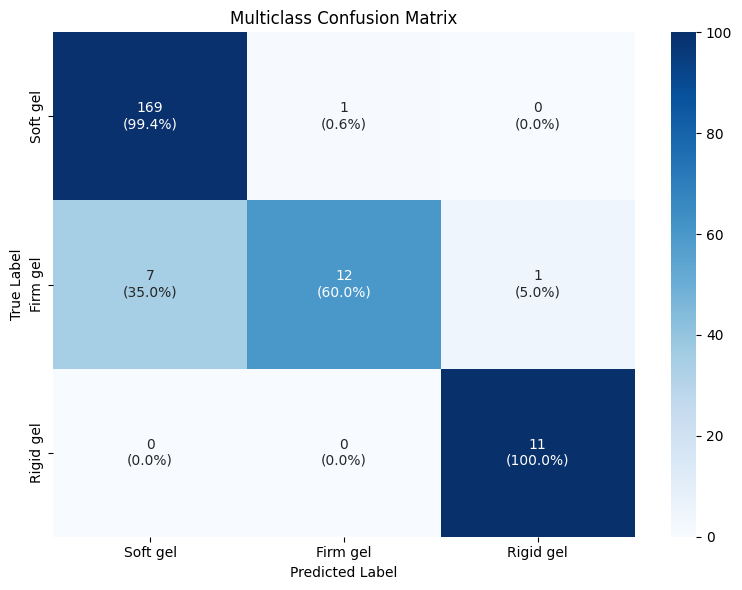

In [55]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Class labels
class_names = ["Soft gel", "Firm gel", "Rigid gel"]

# Compute confusion matrix
cm = confusion_matrix(y_test, catboost_model.predict(X_test))  # Raw counts
cm_normalized = confusion_matrix(y_test, catboost_model.predict(X_test), normalize='true')  # Normalize by row to get percentages

# Convert to percentage and format as string
cm_percentage = cm_normalized * 100
cm_labels = np.array([f"{count}\n({value:.1f}%)" for count, value in zip(cm.flatten(), cm_percentage.flatten())]).reshape(cm.shape)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=cm_labels, fmt='', cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Add title and labels
plt.title("Multiclass Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [56]:
catboost_ypred = catboost_model.predict(X_test)
print(f1_score(y_test, catboost_ypred, average='weighted'))


0.9509281484464629


In [57]:
catboost_ypred = catboost_model.predict(X_test)
print(accuracy_score(y_test, catboost_ypred))

0.9552238805970149


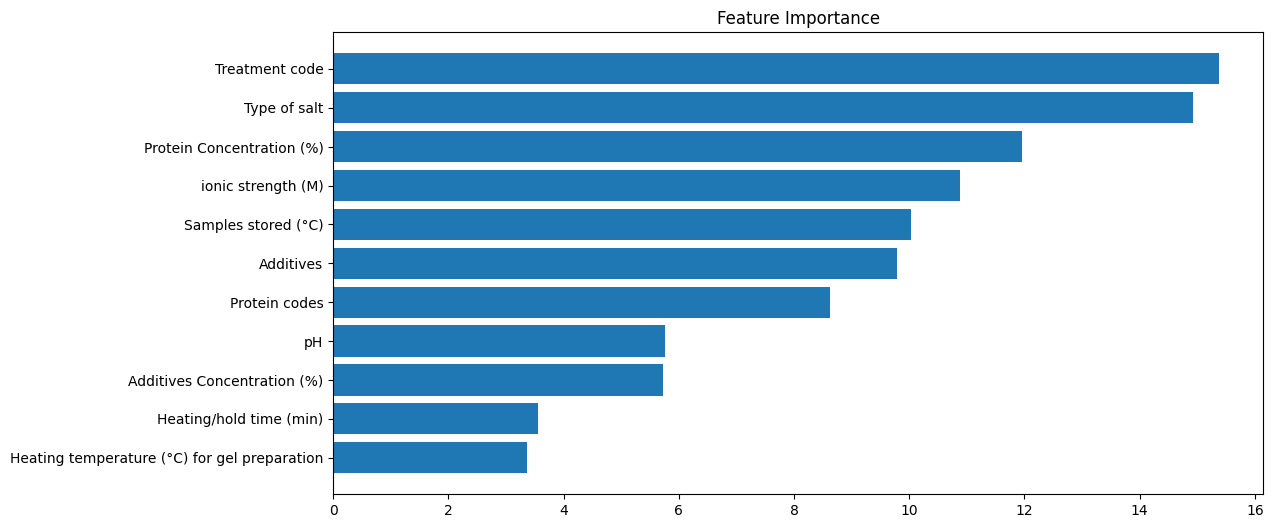

In [58]:
from matplotlib import pyplot as plt

feature_importance = catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

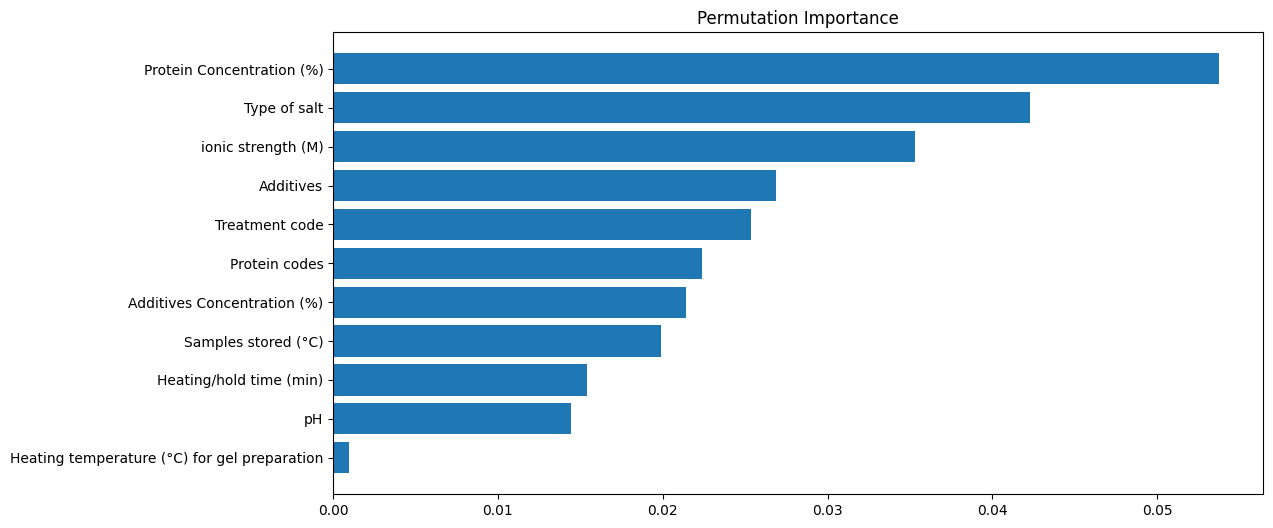

In [59]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(catboost_model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')
plt.show()